In [1]:
from crear_dataset import *
from funcions_net import *
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat
import pandas as pd
from preprocessing import *
from sklearn.model_selection import train_test_split
from func_sel import *
from funcions_net import *


In [2]:

df_orig, meta = pyreadstat.read_sav("CEJFEAjut2015Updated.sav")

df_variables = pd.read_csv("variables.csv", sep=';')

dict = create_dict(meta)

df = drop_all_columns(df_orig, meta, df_variables, dict)

df = origen(df,df_orig)


df['temps_fins_reincidencia1a'] = df['temps_fins_reincidencia1a'].apply(lambda x: 1095 if x > 1095 else x)


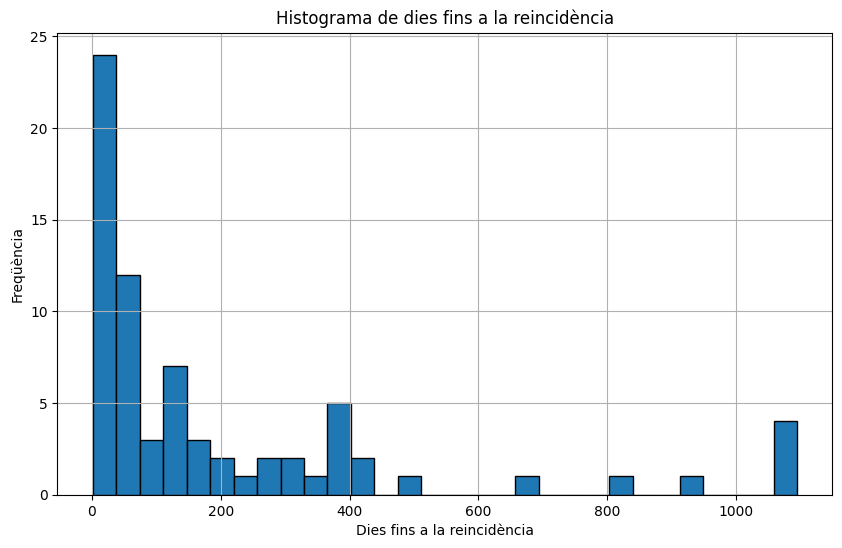

In [4]:
# Aplicació del límit superior de 1095 dies
df['temps_fins_reincidencia1a'] = df['temps_fins_reincidencia1a'].apply(lambda x: 1095 if x > 1095 else x)

# Creació de l'histograma
plt.figure(figsize=(10, 6))
plt.hist(df['temps_fins_reincidencia1a'], bins=30, edgecolor='black')
plt.title("Histograma de dies fins a la reincidència")
plt.xlabel("Dies fins a la reincidència")
plt.ylabel("Freqüència")
plt.grid(True)
plt.show()

In [ ]:
print("Mirem quants nans tenim a cada columna")
netejat,df = neteja_na_columns(df, llindar=0.6)

df = omple_nans(df)

print("Columnes netejades")
## fem label encoding de les columnes categòriques
df = label_encoding(df)

print(df)

Mirem quants nans tenim a cada columna
Columnes netejades


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\preprocessing.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_net[col].fillna(mitjana, inplace=True)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\preprocessing.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [4]:
num_columnes = df.shape[1]
print("Hem netejat les columnes i hem fet label encoding")
print("Tenim ", num_columnes, " columnes")

Hem netejat les columnes i hem fet label encoding
Tenim  441  columnes


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='temps_fins_reincidencia1a'), df['temps_fins_reincidencia1a'], test_size=0.2,random_state=42)


In [6]:
X_train_filtrat, coef_significatius = filter_significant_features(X_train,y_train, df, llindar=0.01,alpha=0.01, print_results=True)

Hem fet el model Lasso
Hem trobat  245  coeficients nuls
Hem trobat  195  coeficients no nuls
Els coeficients no nuls són:
EdatAD                      50.569196
TempsResidencia              0.302755
TempConeixTutor              1.775276
TempConeixMestre            -0.226011
NSancGreu                  -11.677583
                              ...    
nDelictesViolents           -3.250957
t_lliure_1areincviolenta    -0.010028
RPQ_HIGH_PA_RA               7.029627
Magrebins                    0.142163
Pares_Catalans              -1.063234
Length: 195, dtype: float64
Els coeficients nuls són:
NSancLleu                       0.0
Del_Sobre                      -0.0
Pri_Ing                         0.0
RAVENbarem                     -0.0
RavenZ                         -0.0
                               ... 
Pare_Catala_Altres_Espanya      0.0
Pare_Catala_Fora_Espanya        0.0
Pares_No_Catalans_Espanya      -0.0
Pares_No_Catalans_Un_Espanya    0.0
Pares_Fora_Espanya              0.0
Length: 2

c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.911e+02, tolerance: 1.874e+02
  model = cd_fast.enet_coordinate_descent(


In [7]:
## ensenyem els coef mes grans

maxims = np.sort(abs(coef_significatius))[::-1]

# Printem els índexs dels coeficients més grans
index_maxims = np.argsort(abs(coef_significatius))[::-1]
print(index_maxims[10:20])

fets_sobresegut_definitiu_preCAPE     12
fets_absolt_preCAPE                   65
nombre_fets_previs                    97
NsancionsMGreusAvalNostraFinal        85
NsancionsMGreusIniciFinsAvalNostra    49
NsancionsGreusAvalNostraFinal         70
NsancionsGreusIniciFinsAvalNostra     95
SANCGrMGr                             39
YSRGrupDSMCDCAPEe                     47
TRFTGrupDSMCDConsCAPEe                45
dtype: int64


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## fem grid search per trobar els millors hiperparàmetres

param_grid = {
    'n_estimators': [100,250,500],
    'max_depth': [30,50,75],
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

# Realitzem el Grid Search
grid_search.fit(X_train_filtrat, y_train)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

# Mostrem la mitjana dels resultats de test
print("Mitjana dels resultats de test per cada combinació:")
print(np.mean(grid_search.cv_results_['mean_test_score'] * -1))  # Multipliquem per -1 per obtenir el MSE positiu

best_model = grid_search.best_estimator_


Millor paràmetre: {'max_depth': 50, 'n_estimators': 500}
Millor precisió: 36888.23779252
Mitjana dels resultats de test per cada combinació:
37474.3910337437


In [9]:
# Obtenim la importància de cada característica
coef_importants = best_model.feature_importances_

# Obtenim els noms de les característiques (suposant que tenim un DataFrame 'df')
feature_names = X_train_filtrat.columns  

# Ordenem les característiques segons la seva importància (de major a menor)
indices_ordenats = coef_importants.argsort()[::-1][0:25]

# Mostrem els noms de les 20 característiques més importants amb la seva importància
print("Les 20 característiques més importants són:")
for i in indices_ordenats:
    print(f"{feature_names[i]}: {coef_importants[i]:.4f}")



Les 20 característiques més importants són:
t_internamentCape: 0.0559
nDelictesViolents: 0.0537
YPI_LY: 0.0412
CAPEe04: 0.0358
PCLjFAC_3: 0.0348
EdatAD: 0.0334
Del_Condem: 0.0268
TempConeixTutor: 0.0225
SAVRY29: 0.0180
TRFMTotProb: 0.0176
NsancionsGreusAvalNostraFinal: 0.0175
VASTDir: 0.0161
PCLoFAC_3: 0.0156
Total_Del: 0.0156
SAVRYTot: 0.0152
VAST12: 0.0151
Nom_Exp: 0.0148
DD02: 0.0147
PCLo09: 0.0129
RAVEN04: 0.0119
TriPMTotal: 0.0111
SAVRY01: 0.0104
PCLo11: 0.0103
SAVRYInd: 0.0101
TriPMDisi: 0.0087


In [10]:
# Obtenim la importància de cada característica
coef_importants = best_model.feature_importances_

# Obtenim els noms de les característiques (suposant que tenim un DataFrame 'df')
feature_names = X_train_filtrat.columns  

# Ordenem les característiques segons la seva importància (de major a menor)
indices_ordenats = coef_importants.argsort()[::-1][25:40]

# Mostrem els noms de les 20 característiques més importants amb la seva importància
print("Les 20 característiques més importants són:")
for i in indices_ordenats:
    print(f"{feature_names[i]}: {coef_importants[i]:.4f}")



Les 20 característiques més importants són:
TRFTDSMAnxProbT: 0.0086
DD04: 0.0083
DD07: 0.0080
SD3Narc: 0.0079
SAVRYSoc: 0.0078
CCA_AG: 0.0076
TempConeixMestre: 0.0073
VAST02: 0.0072
PCLYVMFAC_2: 0.0071
TriPMBold: 0.0071
TempsLlibertat: 0.0068
PCLoFAC_1: 0.0068
VAST01: 0.0068
Edat1erDelicte: 0.0068
fets_presumpte_preCAPE: 0.0064
